In [1]:
import pandas as pd
import numpy as np
import scprep, scanpy
import networkx as nx
import sys
sys.path.append('/home/aarthivenkat/cell_cell_comm/graph_scattering_FINAL')
from run import graphscattering as gs
import phate
import omnipath
import sklearn

import keras
import tensorflow as tf
from keras import layers
import tensorflow_addons as tfa
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from run.run_ae_with_supcon import run_ae_with_supcon

/home/aarthivenkat/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/aarthivenkat/.local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Preprocess single-cell data

In [1452]:
conv = {'Astro': 'Astrocyte', 'Endo': 'Endothelial Cell', 'Micro': 'Microglia',
 'Oligo': 'Oligodendrocyte', 'OPC': 'Oligodendrocyte Precursor Cell',
        'Ndnf': 'GABA-ergic Neuron', 'Pvalb': 'GABA-ergic Neuron',
       'Sst': 'GABA-ergic Neuron', 'Vip': 'GABA-ergic Neuron', 'Igtp/Smad3': 'GABA-ergic Neuron',
       'L2/3': 'Glutamatergic Neuron', 'L4_Ctxn3/Scnn1a': 'Glutamatergic Neuron', 'L5a':'Glutamatergic Neuron',
       'L5b':'Glutamatergic Neuron', 'L6a':'Glutamatergic Neuron', 'L6b':'Glutamatergic Neuron'}

In [1453]:
cell_types = np.unique(list(conv.values()))

In [1454]:
data = pd.read_csv('data/visual_cortex_GSE71585_RefSeq_counts.csv.gz', index_col=0).T
metadata = pd.read_csv('data/visual_cortex_GSE71585_Clustering_Results.csv.gz', index_col=0)

mask = metadata['broad_type'].isin(cell_types)
data = data[mask] ## all but unclassified
metadata = metadata[mask] ## all but unclassified
data = scprep.transform.log(data)

argsort = [np.argwhere(metadata.index[i] == data.index)[0][0] for i in range(1727)]
data = data.iloc[argsort]
edata = scanpy.AnnData(data, obs=metadata)

<ipython-input-1454-7f987f9f2a05>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[mask] ## all but unclassified


In [1466]:
phate_op = phate.PHATE(random_state=0)
data_phate = phate_op.fit_transform(data)

Calculating PHATE...
  Running PHATE on 1727 observations and 24057 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.47 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.24 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 2.78 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 1.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.21 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.95 seconds.
Calculated PHATE in 8.06 seconds.


<AxesSubplot:title={'center':'Visual Cortex (scRNA-seq)'}>

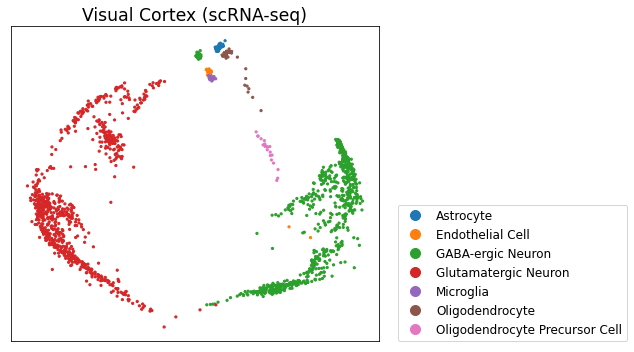

In [1477]:
scprep.plot.scatter2d(data_phate, c=metadata['broad_type'], legend_loc=(1.05,0), title='Visual Cortex (scRNA-seq)',
                      figsize=(9,5), ticks=None, dpi=200, filename='results/scRNA_cell_types.png')

## Get DEGs

In [171]:
scanpy.tl.rank_genes_groups(edata, groupby='broad_type', method='wilcoxon')

In [199]:
cell_type_de = {}
for ct in cell_types:
    cell_type_de[ct] = scanpy.get.rank_genes_groups_df(edata, ct)
    mask = (cell_type_de[ct]['logfoldchanges'] > 2) & (cell_type_de[ct]['pvals_adj'] < 0.05)
    cell_type_de[ct] = cell_type_de[ct][mask]

## Subset OmniPath Graph to DEGs for two cell types and get biggest CC

In [293]:
human_to_mouse = pd.read_csv('data/HMD_HumanPhenotype.rpt', sep='\t', header=None)
mouse_to_human = defaultdict(list)
for row in human_to_mouse.iterrows():
    mouse_to_human[row[1][2]].append(row[1][0])

In [ ]:
intercellular = omnipath.interactions.import_intercell_network()
intercellular_genesymbol = intercellular[['genesymbol_intercell_source', 'genesymbol_intercell_target']]
intercellular_genesymbol.columns = ['source', 'target']
intercellular_genesymbol = intercellular_genesymbol.drop_duplicates()

In [294]:
df = pd.read_csv('data/omnipath_curated_interactions.csv', index_col = 0)
G = nx.from_pandas_edgelist(df=df, source='source_genesymbol', target='target_genesymbol', create_using=nx.DiGraph)
Gcc = sorted(nx.connected_components(nx.to_undirected(G)), key=len, reverse=True)
G = G.subgraph(Gcc[0]) 

In [305]:
ct1 = 'Astrocyte'
ct2 = 'Endothelial Cell'
subgraph_nodes_ct1 = cell_type_de[ct1]['names'].values
subgraph_nodes_ct2 = cell_type_de[ct2]['names'].values

In [300]:
subgraph_nodes_ct1_human = []
for convs in [mouse_to_human[x] for x in subgraph_nodes_ct1]:
    human_nodes_in_graph = list(set(convs).intersection(G.nodes()))
    subgraph_nodes_ct1_human.extend(human_nodes_in_graph)

In [306]:
subgraph_nodes_ct2_human = []
for convs in [mouse_to_human[x] for x in subgraph_nodes_ct2]:
    human_nodes_in_graph = list(set(convs).intersection(G.nodes()))
    subgraph_nodes_ct2_human.extend(human_nodes_in_graph)

In [1308]:
# remove DEGs belonging to both cell types
inter = set(subgraph_nodes_ct1_human).intersection(subgraph_nodes_ct2_human)
combined = set(np.hstack((subgraph_nodes_ct1_human, subgraph_nodes_ct2_human))) - inter

In [410]:
G = G.subgraph(combined)
Gcc = sorted(nx.connected_components(nx.to_undirected(G)), key=len, reverse=True)
G = G.subgraph(Gcc[0])

In [1309]:
node_df = pd.DataFrame(index=G.nodes())

In [1373]:
node_label = []
for node in G.nodes():
    if (node in subgraph_nodes_ct1_human) & (node in subgraph_nodes_ct2_human):
        node_label.append(ct1 +'_'+ ct2)
    elif (node in subgraph_nodes_ct1_human):
        node_label.append(ct1)
    elif (node in subgraph_nodes_ct2_human):
        node_label.append(ct2)
node_df['node_label'] = node_label

In [1376]:
edge_df = pd.DataFrame(G.edges())
node_conv = dict(zip(node_df.index,node_df['node_label']))
edge_df['0_node'] = [node_conv[x] for x in edge_df[0]]
edge_df['1_node'] = [node_conv[x] for x in edge_df[1]]
edge_df['intercellular'] = [sum((intercellular_genesymbol['source'] == edge[0]) & (intercellular_genesymbol['target'] == edge[1])) for edge in G.edges()]

In [1389]:
intercellular_nodes = edge_df[(edge_df['intercellular'] == 1) & (edge_df['0_node'] != edge_df['1_node'])][[0,1]].values.flatten()
node_df['intercellular_label'] = np.array([node_df.loc[x]['node_label'] if x not in intercellular_nodes else 'Intercellular' for x in node_df.index])

## Run Directed Scattering

In [412]:
A = nx.adjacency_matrix(G).toarray()
N = A.shape[0]
signal = np.random.randn(N, 1)

In [413]:
q=0.1, J=15
vals, vecs = gs.compute_eigen(A, q)
scales = np.flip(np.arange(0, J+1))
all_features = gs.compute_all_features(vals, vecs, signal, N, "lowpass", scales)
ds_ct1_ct2 = pd.DataFrame(data=all_features, index=G.nodes())
ds_ct1_ct2.to_csv(f'results/{ct1}_{ct2}_{J}_q{q}_omnipath_embedding.csv', compression='gzip')

In [1478]:
data_phate = phate.PHATE(verbose=False, random_state=0).fit_transform(ds_ct1_ct2)

<AxesSubplot:title={'center':'Without classifer\nIntercellular Label'}, xlabel='PHATE1', ylabel='PHATE2'>

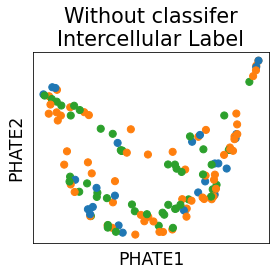

In [1497]:
scprep.plot.scatter2d(data_phate, c=node_df['intercellular_label'], ticks=None, legend=False, figsize=(4,4), s=50,
                     filename='results/without_classifiers_intercellular_label.png', dpi=200, label_prefix='PHATE', fontsize=12,
                     title='Without classifer\nIntercellular Label')

<AxesSubplot:title={'center':'Without classifer\nIntracellular Label'}, xlabel='PHATE1', ylabel='PHATE2'>

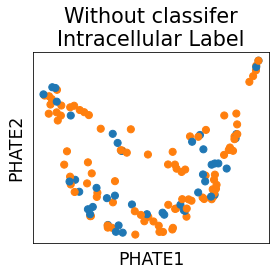

In [1498]:
scprep.plot.scatter2d(data_phate, c=node_df['node_label'], ticks=None, legend=False, figsize=(4,4), s=50,
                      filename='results/without_classifier_deg_label.png', dpi=200, label_prefix='PHATE', fontsize=12,
                      title='Without classifer\nIntracellular Label')

## Run AE with Reconstruction Loss, SupCon loss to distinguish astrocyte and endothelial DEGs, and SupCon loss to bring together astrocyte <-> endothelial intercellular connections

In [11]:
ct1 = 'Astrocyte'
ct2 = 'Endothelial Cell'
q=0.1
J=15
ds_ct1_ct2 = pd.read_csv(f'results/{ct1}_{ct2}_{J}_q{q}_omnipath_embedding.csv', compression='gzip', index_col=0)
node_df = pd.read_csv(f'results/{ct1}_{ct2}_{J}_q{q}_node_df.csv', index_col=0)

In [13]:
y1 = LabelEncoder().fit_transform(node_df['node_label'])
y2 = LabelEncoder().fit_transform(node_df['intercellular_label'])

In [14]:
epochs = 500
patience = epochs // 2
ds_ae = run_ae_with_supcon(ds_ct1_ct2.values, y1, y2, epochs=epochs, patience=epochs)

Epoch 1/500
5/5 [==============================] - 1s 5ms/step - loss: 20.3338 - decoder_loss: 0.0020 - classifier1_loss: 3.3866 - classifier2_loss: 3.3804
Epoch 2/500
5/5 [==============================] - 0s 4ms/step - loss: 20.2762 - decoder_loss: 0.0014 - classifier1_loss: 3.3782 - classifier2_loss: 3.3715
Epoch 3/500
5/5 [==============================] - 0s 4ms/step - loss: 20.2914 - decoder_loss: 0.0011 - classifier1_loss: 3.3819 - classifier2_loss: 3.3712
Epoch 4/500
5/5 [==============================] - 0s 4ms/step - loss: 20.2928 - decoder_loss: 8.2425e-04 - classifier1_loss: 3.3817 - classifier2_loss: 3.3763
Epoch 5/500
5/5 [==============================] - 0s 4ms/step - loss: 20.2989 - decoder_loss: 6.7918e-04 - classifier1_loss: 3.3829 - classifier2_loss: 3.3774
Epoch 6/500
5/5 [==============================] - 0s 4ms/step - loss: 20.2784 - decoder_loss: 5.7393e-04 - classifier1_loss: 3.3809 - classifier2_loss: 3.3679
Epoch 7/500
5/5 [==============================] - 0

5/5 [==============================] - 0s 4ms/step - loss: 20.1077 - decoder_loss: 7.4647e-05 - classifier1_loss: 3.3704 - classifier2_loss: 3.2550
Epoch 53/500
5/5 [==============================] - 0s 4ms/step - loss: 20.1729 - decoder_loss: 6.4385e-05 - classifier1_loss: 3.3805 - classifier2_loss: 3.2695
Epoch 54/500
5/5 [==============================] - 0s 4ms/step - loss: 20.1383 - decoder_loss: 5.6748e-05 - classifier1_loss: 3.3800 - classifier2_loss: 3.2376
Epoch 55/500
5/5 [==============================] - 0s 4ms/step - loss: 20.0808 - decoder_loss: 5.3606e-05 - classifier1_loss: 3.3791 - classifier2_loss: 3.1847
Epoch 56/500
5/5 [==============================] - 0s 4ms/step - loss: 20.0878 - decoder_loss: 4.7621e-05 - classifier1_loss: 3.3768 - classifier2_loss: 3.2035
Epoch 57/500
5/5 [==============================] - 0s 4ms/step - loss: 20.0946 - decoder_loss: 4.3527e-05 - classifier1_loss: 3.3719 - classifier2_loss: 3.2346
Epoch 58/500
5/5 [=============================

5/5 [==============================] - 0s 4ms/step - loss: 18.7734 - decoder_loss: 3.1689e-05 - classifier1_loss: 3.1539 - classifier2_loss: 3.0037
Epoch 103/500
5/5 [==============================] - 0s 5ms/step - loss: 18.9954 - decoder_loss: 3.2144e-05 - classifier1_loss: 3.2019 - classifier2_loss: 2.9854
Epoch 104/500
5/5 [==============================] - 0s 4ms/step - loss: 19.0733 - decoder_loss: 3.5556e-05 - classifier1_loss: 3.2133 - classifier2_loss: 3.0063
Epoch 105/500
5/5 [==============================] - 0s 4ms/step - loss: 18.6011 - decoder_loss: 3.0570e-05 - classifier1_loss: 3.1196 - classifier2_loss: 3.0026
Epoch 106/500
5/5 [==============================] - 0s 4ms/step - loss: 18.4065 - decoder_loss: 3.5070e-05 - classifier1_loss: 3.0874 - classifier2_loss: 2.9690
Epoch 107/500
5/5 [==============================] - 0s 4ms/step - loss: 18.3084 - decoder_loss: 2.7737e-05 - classifier1_loss: 3.0544 - classifier2_loss: 3.0361
Epoch 108/500
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 18.5426 - decoder_loss: 2.3139e-05 - classifier1_loss: 3.1164 - classifier2_loss: 2.9601
Epoch 153/500
5/5 [==============================] - 0s 4ms/step - loss: 18.2062 - decoder_loss: 2.2378e-05 - classifier1_loss: 3.0528 - classifier2_loss: 2.9418
Epoch 154/500
5/5 [==============================] - 0s 4ms/step - loss: 17.9237 - decoder_loss: 1.8824e-05 - classifier1_loss: 3.0024 - classifier2_loss: 2.9114
Epoch 155/500
5/5 [==============================] - 0s 4ms/step - loss: 17.9267 - decoder_loss: 1.6688e-05 - classifier1_loss: 3.0059 - classifier2_loss: 2.8972
Epoch 156/500
5/5 [==============================] - 0s 4ms/step - loss: 17.7942 - decoder_loss: 1.6476e-05 - classifier1_loss: 2.9793 - classifier2_loss: 2.8974
Epoch 157/500
5/5 [==============================] - 0s 4ms/step - loss: 17.7814 - decoder_loss: 1.4601e-05 - classifier1_loss: 2.9809 - classifier2_loss: 2.8766
Epoch 158/500
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 17.6086 - decoder_loss: 9.4139e-06 - classifier1_loss: 2.9560 - classifier2_loss: 2.8283
Epoch 203/500
5/5 [==============================] - 0s 4ms/step - loss: 17.6375 - decoder_loss: 9.6426e-06 - classifier1_loss: 2.9637 - classifier2_loss: 2.8187
Epoch 204/500
5/5 [==============================] - 0s 4ms/step - loss: 17.6348 - decoder_loss: 9.3229e-06 - classifier1_loss: 2.9590 - classifier2_loss: 2.8398
Epoch 205/500
5/5 [==============================] - 0s 4ms/step - loss: 17.7006 - decoder_loss: 9.4409e-06 - classifier1_loss: 2.9771 - classifier2_loss: 2.8152
Epoch 206/500
5/5 [==============================] - 0s 4ms/step - loss: 17.6929 - decoder_loss: 9.2444e-06 - classifier1_loss: 2.9732 - classifier2_loss: 2.8270
Epoch 207/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5575 - decoder_loss: 8.8175e-06 - classifier1_loss: 2.9466 - classifier2_loss: 2.8246
Epoch 208/500
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 18.7915 - decoder_loss: 1.9812e-05 - classifier1_loss: 3.1679 - classifier2_loss: 2.9518
Epoch 253/500
5/5 [==============================] - 0s 4ms/step - loss: 18.6995 - decoder_loss: 2.1144e-05 - classifier1_loss: 3.1534 - classifier2_loss: 2.9324
Epoch 254/500
5/5 [==============================] - 0s 4ms/step - loss: 18.7141 - decoder_loss: 2.2620e-05 - classifier1_loss: 3.1464 - classifier2_loss: 2.9819
Epoch 255/500
5/5 [==============================] - 0s 4ms/step - loss: 18.5573 - decoder_loss: 2.6083e-05 - classifier1_loss: 3.1307 - classifier2_loss: 2.9035
Epoch 256/500
5/5 [==============================] - 0s 4ms/step - loss: 18.5321 - decoder_loss: 2.2633e-05 - classifier1_loss: 3.1201 - classifier2_loss: 2.9313
Epoch 257/500
5/5 [==============================] - 0s 4ms/step - loss: 18.3880 - decoder_loss: 2.1612e-05 - classifier1_loss: 3.0846 - classifier2_loss: 2.9646
Epoch 258/500
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 17.6292 - decoder_loss: 6.9398e-06 - classifier1_loss: 2.9571 - classifier2_loss: 2.8436
Epoch 303/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5997 - decoder_loss: 6.8326e-06 - classifier1_loss: 2.9589 - classifier2_loss: 2.8050
Epoch 304/500
5/5 [==============================] - 0s 4ms/step - loss: 17.4954 - decoder_loss: 6.9178e-06 - classifier1_loss: 2.9377 - classifier2_loss: 2.8066
Epoch 305/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5599 - decoder_loss: 6.8348e-06 - classifier1_loss: 2.9507 - classifier2_loss: 2.8062
Epoch 306/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5366 - decoder_loss: 6.7876e-06 - classifier1_loss: 2.9445 - classifier2_loss: 2.8141
Epoch 307/500
5/5 [==============================] - 0s 4ms/step - loss: 17.6332 - decoder_loss: 6.9979e-06 - classifier1_loss: 2.9642 - classifier2_loss: 2.8119
Epoch 308/500
5/5 [=======================

5/5 [==============================] - 0s 3ms/step - loss: 19.1350 - decoder_loss: 1.7637e-05 - classifier1_loss: 3.2281 - classifier2_loss: 2.9942
Epoch 353/500
5/5 [==============================] - 0s 3ms/step - loss: 19.0561 - decoder_loss: 1.5574e-05 - classifier1_loss: 3.2069 - classifier2_loss: 3.0213
Epoch 354/500
5/5 [==============================] - 0s 3ms/step - loss: 18.4499 - decoder_loss: 1.6861e-05 - classifier1_loss: 3.0802 - classifier2_loss: 3.0489
Epoch 355/500
5/5 [==============================] - 0s 3ms/step - loss: 18.0964 - decoder_loss: 1.7590e-05 - classifier1_loss: 3.0238 - classifier2_loss: 2.9772
Epoch 356/500
5/5 [==============================] - 0s 4ms/step - loss: 18.1381 - decoder_loss: 1.4460e-05 - classifier1_loss: 3.0421 - classifier2_loss: 2.9274
Epoch 357/500
5/5 [==============================] - 0s 4ms/step - loss: 17.9788 - decoder_loss: 1.3830e-05 - classifier1_loss: 3.0160 - classifier2_loss: 2.8985
Epoch 358/500
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 17.5388 - decoder_loss: 5.2420e-06 - classifier1_loss: 2.9514 - classifier2_loss: 2.7820
Epoch 403/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5303 - decoder_loss: 5.1051e-06 - classifier1_loss: 2.9514 - classifier2_loss: 2.7732
Epoch 404/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5664 - decoder_loss: 5.1433e-06 - classifier1_loss: 2.9581 - classifier2_loss: 2.7759
Epoch 405/500
5/5 [==============================] - 0s 4ms/step - loss: 17.4654 - decoder_loss: 4.9860e-06 - classifier1_loss: 2.9416 - classifier2_loss: 2.7571
Epoch 406/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5225 - decoder_loss: 5.2554e-06 - classifier1_loss: 2.9487 - classifier2_loss: 2.7791
Epoch 407/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5065 - decoder_loss: 4.9366e-06 - classifier1_loss: 2.9454 - classifier2_loss: 2.7796
Epoch 408/500
5/5 [=======================

5/5 [==============================] - 0s 4ms/step - loss: 17.5412 - decoder_loss: 4.0443e-06 - classifier1_loss: 2.9496 - classifier2_loss: 2.7931
Epoch 453/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5638 - decoder_loss: 4.0563e-06 - classifier1_loss: 2.9555 - classifier2_loss: 2.7863
Epoch 454/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5335 - decoder_loss: 3.7073e-06 - classifier1_loss: 2.9495 - classifier2_loss: 2.7862
Epoch 455/500
5/5 [==============================] - 0s 4ms/step - loss: 17.6240 - decoder_loss: 3.7234e-06 - classifier1_loss: 2.9711 - classifier2_loss: 2.7682
Epoch 456/500
5/5 [==============================] - 0s 4ms/step - loss: 17.5975 - decoder_loss: 3.6003e-06 - classifier1_loss: 2.9639 - classifier2_loss: 2.7779
Epoch 457/500
5/5 [==============================] - 0s 4ms/step - loss: 17.4714 - decoder_loss: 3.5044e-06 - classifier1_loss: 2.9383 - classifier2_loss: 2.7798
Epoch 458/500
5/5 [=======================

In [15]:
phate_op = phate.PHATE(verbose=False, random_state=2)
data_phate_with_classifer = phate_op.fit_transform(ds_ae)

<AxesSubplot:title={'center':'With classifer\nIntracellular Label'}, xlabel='PHATE1', ylabel='PHATE2'>

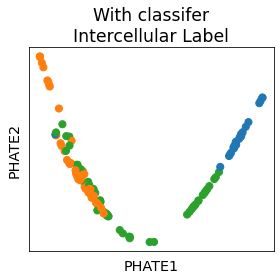

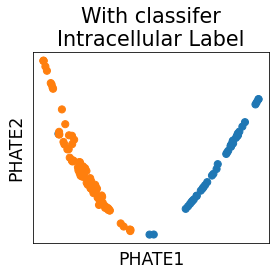

In [16]:
scprep.plot.scatter2d(data_phate_with_classifer, c=node_df['intercellular_label'], ticks=None, legend=False, figsize=(4,4), s=50,
                     filename='results/with_classifiers_intercellular_label.png', dpi=200, label_prefix='PHATE', fontsize=12, title='With classifer\nIntercellular Label')
scprep.plot.scatter2d(data_phate_with_classifer, c=node_df['node_label'], ticks=None, legend=False, figsize=(4,4), s=50,
                      filename='results/with_classifier_deg_label.png', dpi=200, label_prefix='PHATE', fontsize=12, title='With classifer\nIntracellular Label')

In [1422]:
ds_ae = pd.DataFrame(ds_ae, index=G.nodes())

In [1423]:
ds_ae.to_csv(f'results/{ct1}_{ct2}_{J}_q{q}_omnipath_AE.csv', compression='gzip')

## Build graph from DS-AE by PHATE operator, then, since graph is undirected, learn direction of each edge by training on directed classifier

In [1428]:
train_edges = []
for edge in G.edges():
    train_edges.append(np.hstack((ds_ae.loc[edge[0]], ds_ae.loc[edge[1]])))
train_edges = np.array(train_edges)

neg_edges = []
for edge in G.edges():
    neg_edges.append(np.hstack((ds_ae.loc[edge[1]], ds_ae.loc[edge[0]])))
neg_edges = np.array(neg_edges)

In [1429]:
y = [1]*train_edges.shape[0] + [0]*neg_edges.shape[0]

In [1430]:
clf = sklearn.linear_model.RidgeClassifier(random_state=0)
clf.fit(np.vstack((train_edges, neg_edges)), y)

RidgeClassifier(random_state=0)

In [1431]:
# triu, only one way edges
edgelist = np.array(np.argwhere(np.triu(phate_op.graph.to_pygsp().A.todense())).tolist())

In [1432]:
source_to_target = clf.decision_function(np.hstack((ds_ae.iloc[edgelist[:, 0]], ds_ae.iloc[edgelist[:, 1]])))
target_to_source = clf.decision_function(np.hstack((ds_ae.iloc[edgelist[:, 1]], ds_ae.iloc[edgelist[:, 0]])))

In [1436]:
directed_edgelist = []
for i,edge in enumerate(edgelist):
    if source_to_target[i] > target_to_source[i]:
        directed_edgelist.append((edge[0], edge[1]))
    else:
        directed_edgelist.append((edge[1], edge[0]))

In [ ]:
directed_df = pd.DataFrame(0, index=range(G.number_of_nodes()), columns=range(G.number_of_nodes()))
for row in np.array(directed_edgelist):
    directed_df.loc[row[0]][row[1]] = 1
    
directed_edgelist_names = []
for i,edge in enumerate(directed_edgelist):
    directed_edgelist_names.append((node_df.index[edge[0]], node_df.index[edge[1]]))
pd.DataFrame(directed_edgelist_names).to_csv(f'results/{ct1}_{ct2}_{J}_q{q}_learned_graph.csv')
node_df.to_csv(f'results/{ct1}_{ct2}_{J}_q{q}_node_df.csv')
df = pd.DataFrame(directed_edgelist_names)